# NOS network panels: topology and delays

**NOTE**: This notebook imports NOS modules from src/. See the repository README section “Running notebooks” for setup.



[lin] using fallback dbar=-0.6000 (src.nos/src.linearisation not available)
[builder] W: shape=(250, 250), rho≈1.0000, density≈0.016, deg(min/mean/max)=(2,4.0,32)
[builder] Saved W.npy and W_meta.json to OUTDIR
[builder] Saved delays_steps.npy (max=17 steps, mean≈7.0±2.0 ms)


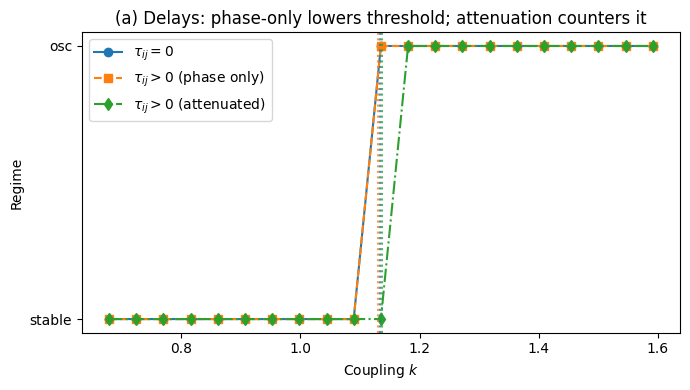

[delay] k* no delay ≈ 1.1333 | phase-only ≈ 1.1306 | attenuated ≈ 1.1370


/tmp/ipython-input-869347349.py:403: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


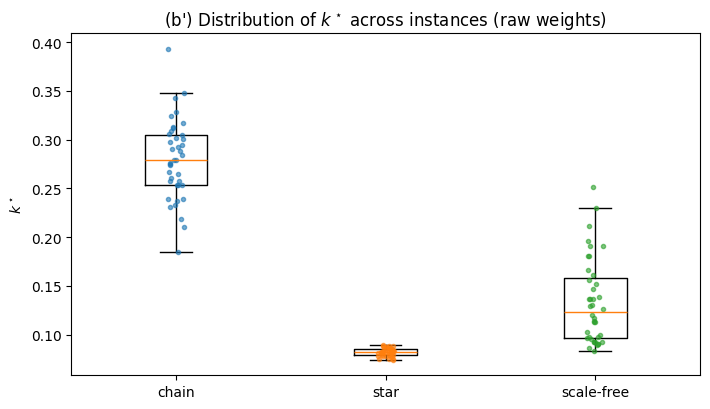

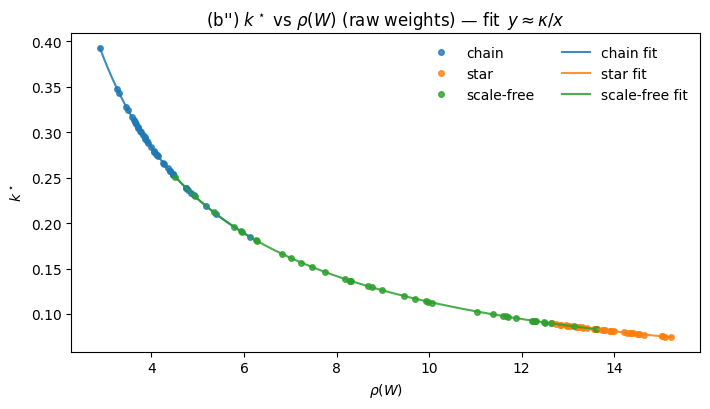

In [ ]:


import os
import sys
from pathlib import Path
import json, math, numpy as np, numpy.linalg as la, matplotlib.pyplot as plt
import networkx as nx

OUTDIR = os.path.join('outputs', 'nos_panels')
os.makedirs(OUTDIR, exist_ok=True)

try:
    _HERE = Path(__file__).resolve().parent
except NameError:
    _HERE = Path.cwd()

if (_HERE / "src").exists():
    sys.path.insert(0, str(_HERE))
elif (_HERE.parent / "src").exists():
    sys.path.insert(0, str(_HERE.parent))

HAVE_SRC_TOPOLOGY = False
HAVE_SRC_LINEARISATION = False

try:
    from src.topology import TopologySpec, build_topology, spectral_radius as _spectral_radius
    HAVE_SRC_TOPOLOGY = True
except Exception:
    TopologySpec = None
    build_topology = None
    _spectral_radius = None

try:
    from src.linearisation import leading_real_part_eig as _leading_real_part_eig
    HAVE_SRC_LINEARISATION = True
except Exception:
    _leading_real_part_eig = None

HAVE_SRC_NOS = False
try:
    from src.nos import NOSParams
    HAVE_SRC_NOS = True
except Exception:
    NOSParams = None

try:
    from src.linearisation import LinPoint as _LinPoint
    from src.linearisation import effective_dbar as _effective_dbar
    from src.linearisation import block_jacobian as _block_jacobian
    from src.linearisation import block_jacobian_delay_surrogate as _block_jacobian_delay_surrogate
    from src.linearisation import find_k_star_bisect as _find_k_star_bisect
    HAVE_SRC_LINEARISATION = True
except Exception:
    _LinPoint = None
    _effective_dbar = None
    _block_jacobian = None
    _block_jacobian_delay_surrogate = None
    _find_k_star_bisect = None



# ========================
# User knobs
# ======================
TOPOLOGY    = "scale-free"   # "chain" | "star" | "scale-free"
N           = 250
SEED        = 5

# Edge weights / symmetry / normalisation
WEIGHTED    = True           # add positive weights
LOGN_SIG    = 0.7            # lognormal sigma (0.4–0.9 reasonable)
SYMMETRISE  = True           # undirected-like W = (A+A^T)/2
NORMALISE   = True           # True: scale W so rho(W)=1 (single-network panels)

# Optional delays
MAKE_DELAYS = True
tau0_ms     = 7.0            # mean one-hop delay
jitter_ms   = 2.0            # ± jitter
dt          = 0.0005         # simulator step for conversion (s)

# Local linearisation terms for block Jacobian (surrogate around an operating point v*)
a, b, mu = 1.0, 0.8, 0.5
vstar    = 0.20

# NOSParams used to compute the paper proxy:
#   dbar = f_sat'(v*) + beta - lam - chi
# Defaults are chosen so dbar≈-0.6 when f_sat'≈0 (alpha=0).
_lin_alpha, _lin_kappa = 0.0, 0.0
_lin_beta, _lin_lam, _lin_chi = 0.0, 0.6, 0.0

dbar = -0.6  # fallback if src.nos/src.linearisation not available
# Attenuation for “with delay” (set to 0.0 for pure phase)
lambda_leak = 0.8


# Compute dbar from nos.py + linearisation.py when available
if HAVE_SRC_NOS and HAVE_SRC_LINEARISATION and (_effective_dbar is not None) and (_LinPoint is not None) and (NOSParams is not None):
    _p_lin = NOSParams(
        alpha=float(_lin_alpha),
        kappa=float(_lin_kappa),
        beta=float(_lin_beta),
        gamma=0.0,
        lam=float(_lin_lam),
        chi=float(_lin_chi),
        v_rest=0.0,
        a=float(a),
        b=float(b),
        mu=float(mu),
        theta=1.0,
        thresh_jitter_std=0.0,
        rho_reset=1.0,
        c_reset=0.0,
        du_spike=0.0,
        v_clip=None,
    )
    _lp = _LinPoint(vstar=float(vstar), coupling_through_nonlinearity=False)
    dbar = float(_effective_dbar(_p_lin, _lp))
    print(f"[lin] dbar computed from NOSParams at v*={vstar:.3f}: {dbar:.4f}")
else:
    _p_lin = None
    _lp = None
    print(f"[lin] using fallback dbar={dbar:.4f} (src.nos/src.linearisation not available)")

# ===================
# Builders + diagnostics
# ==================
def _apply_weights(A, rng, sigma):
    if not WEIGHTED: return A.astype(float)
    W = A.astype(float); m = (A != 0)
    W[m] = rng.lognormal(mean=0.0, sigma=sigma, size=m.sum())
    return W

def _make_chain(N, rng):
    G = nx.path_graph(N); A = nx.to_numpy_array(G, dtype=float); np.fill_diagonal(A,0.0)
    W = _apply_weights(A, rng, LOGN_SIG); return 0.5*(W+W.T) if SYMMETRISE else W

def _make_star(N, rng):
    G = nx.star_graph(N-1); A = nx.to_numpy_array(G, dtype=float); np.fill_diagonal(A,0.0)
    W = _apply_weights(A, rng, LOGN_SIG); return 0.5*(W+W.T) if SYMMETRISE else W

def _make_scalefree(N, m=2, seed=1, rng=None):
    G = nx.barabasi_albert_graph(N, m, seed=seed)
    A = nx.to_numpy_array(G, dtype=float)
    if SYMMETRISE: A = 0.5*(A + A.T)
    np.fill_diagonal(A, 0.0)
    # intentionally decouple weight RNG from topology seed for diversity
    W = _apply_weights(A, np.random.default_rng(seed + 1234), LOGN_SIG)
    return W

def build_W_from_src(topology: str, N: int, seed: int) -> np.ndarray:
    """Build W using src/topology.py but with the same sampling order as the original script.

    Notes:
    - We sample independent weights per directed edge (symmetrise=False in TopologySpec).
    - If SYMMETRISE=True, we then average W <- 0.5*(W+W.T) exactly like the original.
    - Normalisation by spectral radius is performed by build_W()
    """
    if not HAVE_SRC_TOPOLOGY:
        raise RuntimeError("src.topology not available")

    kind_map = {"chain": "chain", "star": "star", "scale-free": "scale_free", "scale_free": "scale_free"}
    kind = kind_map.get(topology, None)
    if kind is None:
        raise ValueError("topology must be 'chain' | 'star' | 'scale-free'")

    spec = TopologySpec(
        kind=kind,
        N=int(N),
        m=2,
        symmetrise=False,          # independent weights per directed edge
        directed=False,
        w_lognorm_mean=0.0,
        w_lognorm_sigma=float(LOGN_SIG),
        target_rho=None,
        seed=int(seed),
    )
    W, _meta = build_topology(spec)

    if SYMMETRISE:
        W = 0.5 * (W + W.T)

    return W


def build_W(topology, N, seed):
    # Optional: use canonical src/topology.py for W construction
    if HAVE_SRC_TOPOLOGY and WEIGHTED:
        W = build_W_from_src(topology, N, seed)
    else:
        rng = np.random.default_rng(seed)
        if topology == "chain":       W = _make_chain(N, rng)
        elif topology == "star":      W = _make_star(N, rng)
        elif topology == "scale-free":W = _make_scalefree(N, m=2, seed=seed, rng=rng)
        else: raise ValueError("topology must be 'chain' | 'star' | 'scale-free'")

    vals = la.eigvals(W); rho = float(np.max(np.abs(vals))) if W.size else 1.0
    if NORMALISE and rho > 0:
        W = W / rho
        vals = la.eigvals(W); rho = float(np.max(np.abs(vals)))
    degs = np.sum(W!=0, axis=1)
    density = float(np.count_nonzero(W)/W.size)
    print(f"[builder] W: shape={W.shape}, rho≈{rho:.4f}, density≈{density:.3f}, "
          f"deg(min/mean/max)=({int(degs.min())},{degs.mean():.1f},{int(degs.max())})")
    return W, rho


def make_delays_steps(W, tau0_s, jitter_s, dt, seed=321):
    """Return integer delay matrix masked to edges only."""
    rng = np.random.default_rng(seed)
    N = W.shape[0]
    tau = tau0_s + rng.uniform(-jitter_s, jitter_s, size=(N, N))
    tau = np.clip(tau, 0.0, None)
    D = (tau / dt).astype(int)
    Wmask = (W != 0).astype(int)
    D *= Wmask
    np.fill_diagonal(D, 0)
    return D

# Save artefacts
W, rho = build_W(TOPOLOGY, N, SEED)
np.save(os.path.join(OUTDIR, "W.npy"), W)
with open(os.path.join(OUTDIR, "W_meta.json"), "w") as f:
    json.dump(dict(topology=TOPOLOGY, N=N, seed=SEED, weighted=WEIGHTED,
                   logn_sig=LOGN_SIG, symmetrise=SYMMETRISE, normalise=NORMALISE,
                   rho=float(rho)), f, indent=2)
print("[builder] Saved W.npy and W_meta.json to OUTDIR")
if MAKE_DELAYS:
    D = make_delays_steps(W, tau0_ms/1000.0, jitter_ms/1000.0, dt, seed=321)
    np.save(os.path.join(OUTDIR, "delays_steps.npy"), D)
    print(f"[builder] Saved delays_steps.npy (max={D.max()} steps, mean≈{tau0_ms:.1f}±{jitter_ms:.1f} ms)")

# ========================
# k* calculators (guards)
# ========================
def J_block(W_eff, dbar, a, b, mu):
    N = W_eff.shape[0]; I = np.eye(N)
    A11 = dbar*np.eye(N) + W_eff; A12 = -I
    A21 = (a*b)*I;               A22 = -(a+mu)*I
    return np.block([[A11, A12],[A21, A22]])

def leading_real_eig(A):
    if HAVE_SRC_LINEARISATION and (_leading_real_part_eig is not None):
        return float(_leading_real_part_eig(A))
    return float(np.max(np.real(la.eigvals(A))))

def kstar_no_delay(W, dbar, a, b, mu, k_lo=1e-4, k_hi=1.0):
    """Surrogate k* by bisection on max Re(eig(J)) for the 2N×2N block Jacobian.
    If src.linearisation is available, use its helper so the Jacobian construction matches the paper appendix code.
    """
    if HAVE_SRC_LINEARISATION and (_find_k_star_bisect is not None) and (_p_lin is not None) and (_lp is not None):
        res = _find_k_star_bisect(W=W, p=_p_lin, lp=_lp, k_lo=float(k_lo), k_hi=float(k_hi))
        return float(res[0] if isinstance(res, tuple) else res)

    def phi(k): return leading_real_eig(J_block(k*W, dbar, a, b, mu))
    f_lo, f_hi = phi(k_lo), phi(k_hi)
    it=0
    while f_lo>=0 and it<24: k_lo*=0.5; f_lo=phi(k_lo); it+=1
    it=0
    while f_hi<=0 and it<24: k_hi*=2.0; f_hi=phi(k_hi); it+=1
    if f_lo>=0 or f_hi<=0:
        raise RuntimeError("Failed to bracket k*. Try widening bounds or changing parameters.")
    for _ in range(64):
        km=0.5*(k_lo+k_hi); fm=phi(km)
        if fm>0: k_hi=km
        else:    k_lo=km
        if abs(k_hi-k_lo) < 1e-4*max(1.0,km): break
    return 0.5*(k_lo+k_hi)
def kstar_with_delay(W, Dij, dt, dbar, a, b, mu, omegas, lam=0.0):
    """Return min k* across a frequency scan; lam=0 => phase-only.

    This is a *delay surrogate* (frequency-domain scan), not a full hybrid reset analysis.
    """
    best = np.inf

    use_src = HAVE_SRC_LINEARISATION and (_block_jacobian_delay_surrogate is not None) and (_p_lin is not None) and (_lp is not None)

    for w in omegas:
        if use_src:
            def phi(k):
                J = _block_jacobian_delay_surrogate(
                    W=W,
                    delays_steps=Dij,
                    dt=float(dt),
                    k=float(k),
                    p=_p_lin,
                    lp=_lp,
                    omega=float(w),
                    attenuation_lam=float(lam),
                )
                return float(leading_real_eig(J))
        else:
            tau = Dij * dt
            F = np.exp(-1j*w*tau) * np.exp(-lam*tau)
            def phi(k): return leading_real_eig(J_block(k*(W*F), dbar, a, b, mu))

        # bracket
        k_lo, k_hi = 1e-4, 1.0
        f_lo, f_hi = phi(k_lo), phi(k_hi)
        it=0
        while f_lo>=0 and it<24: k_lo*=0.5; f_lo=phi(k_lo); it+=1
        it=0
        while f_hi<=0 and it<24: k_hi*=2.0; f_hi=phi(k_hi); it+=1
        if f_lo>=0 or f_hi<=0:
            continue

        for _ in range(64):
            km=0.5*(k_lo+k_hi); fm=phi(km)
            if fm>0: k_hi=km
            else:    k_lo=km
            if abs(k_hi-k_lo) < 1e-4*max(1.0,km): break

        best = min(best, 0.5*(k_lo+k_hi))

    if not np.isfinite(best):
        raise RuntimeError("Failed to bracket k*. Try adjusting dbar/a/b/mu or frequency range.")
    return best
# ========================
# Panel (a): delay effects
# ========================
W = np.load(os.path.join(OUTDIR, "W.npy"))
try:
    Dij = np.load(os.path.join(OUTDIR, "delays_steps.npy")).astype(int)
except Exception:
    tau0 = 0.010
    Dij = np.full_like(W, int(round(tau0/dt)), dtype=int); np.fill_diagonal(Dij, 0)

k_nd = kstar_no_delay(W, dbar, a, b, mu)
omegas = np.linspace(0, 200, 121) * 2*np.pi
k_dl_phase = kstar_with_delay(W, Dij, dt, dbar, a, b, mu, omegas, lam=0.0)                 # phase only
k_dl_atten = kstar_with_delay(W, Dij, dt, dbar, a, b, mu, omegas, lam=lambda_leak)         # phase + attenuation

if not (np.isfinite(k_nd) and np.isfinite(k_dl_phase) and np.isfinite(k_dl_atten)):
    raise RuntimeError("Failed to bracket k*. Try adjusting dbar/a/b/mu or frequency range.")

kg = np.linspace(0.6*min(k_nd, k_dl_phase, k_dl_atten),
                 1.4*max(k_nd, k_dl_phase, k_dl_atten), 21)
def regime(k, thr): return 0 if k < thr else 1   # 0=stable, 1=osc (avalanche not used here)
to_y = lambda labels: labels

plt.figure(figsize=(7.0, 4.0))
plt.plot(kg, [regime(k, k_nd)        for k in kg], 'o-',  label=r'$\tau_{ij}=0$')
plt.plot(kg, [regime(k, k_dl_phase)  for k in kg], 's--', label=r'$\tau_{ij}>0$ (phase only)')
plt.plot(kg, [regime(k, k_dl_atten)  for k in kg], 'd-.', label=r'$\tau_{ij}>0$ (attenuated)')
for x,c in [(k_nd,'C0'), (k_dl_phase,'C1'), (k_dl_atten,'C2')]:
    plt.axvline(x, color=c, ls=':', alpha=0.8)
plt.yticks([0,1], ['stable','osc'])
plt.xlabel('Coupling $k$'); plt.ylabel('Regime')
plt.title('(a) Delays: phase-only lowers threshold; attenuation counters it')
plt.legend(); plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, 'panel_delay_fixed.png'), dpi=220); plt.show()

print(f"[delay] k* no delay ≈ {k_nd:.4f} | phase-only ≈ {k_dl_phase:.4f} | attenuated ≈ {k_dl_atten:.4f}")

# =========================================================
# Panels (b′), (b″): topology spread with CORRECT  κ/x fit
# ================================================
rng = np.random.default_rng(7)

def _weightify(A, sigma=0.7):
    W = A.astype(float); m=(A!=0)
    W[m] = rng.lognormal(0.0, sigma, size=m.sum())
    return W

def chain_raw(N):
    G = nx.path_graph(N); A = nx.to_numpy_array(G, dtype=float); np.fill_diagonal(A,0.0)
    return _weightify(A, 0.7)

def star_raw(N):
    G = nx.star_graph(N-1); A = nx.to_numpy_array(G, dtype=float); np.fill_diagonal(A,0.0)
    return _weightify(A, 0.7)

def scalefree_raw(N, m=2, seed=1):
    G = nx.barabasi_albert_graph(N, m, seed=seed)
    A = nx.to_numpy_array(G, dtype=float); A = 0.5*(A+A.T); np.fill_diagonal(A,0.0)
    return _weightify(A, 0.7)

N_ens = 120
records=[]
for topo in ['chain','star','scale-free']:
    for _ in range(40):
        if topo=='chain':
            Wt = chain_raw(N_ens)
        elif topo=='star':
            Wt = star_raw(N_ens)
        else:
            m = int(rng.integers(1,4)); seed=int(rng.integers(1, 1_000_000))
            Wt = scalefree_raw(N_ens, m=m, seed=seed)
        rho = float(np.max(np.abs(la.eigvals(Wt))))
        kc  = kstar_no_delay(Wt, dbar, a, b, mu)
        records.append({'topo':topo,'rho':rho,'kstar':kc})
import pandas as pd
df = pd.DataFrame(records)

# (b′) distribution
plt.figure(figsize=(7.2,4.2))
order=['chain','star','scale-free']
data=[df[df['topo']==t]['kstar'].values for t in order]
plt.boxplot(data, labels=order, showfliers=False)
for i,t in enumerate(order, start=1):
    ks = df[df['topo']==t]['kstar'].values
    xj = i + 0.08*(np.random.rand(len(ks))-0.5)
    plt.plot(xj, ks, 'o', ms=3, alpha=0.6)
plt.ylabel(r'$k^\star$'); plt.title(r"(b') Distribution of $k^\star$ across instances (raw weights)")
plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, "panel_topology_dist_fixed.png"), dpi=220); plt.show()

# (b″) k* vs rho with correct κ/x fit
plt.figure(figsize=(7.2,4.2))
col = dict(chain='C0', star='C1', **{'scale-free':'C2'})
for t in order:
    d = df[df['topo']==t]
    plt.plot(d['rho'], d['kstar'], 'o', ms=4, alpha=0.8, label=t, color=col[t])
# corrected LS fit for y ≈ κ/x
for t in order:
    d = df[df['topo']==t]; x = d['rho'].values; y = d['kstar'].values
    kappa = np.sum(y/x) / np.sum(1.0/(x*x))              # <-- FIXED
    xs = np.linspace(x.min(), x.max(), 200)
    plt.plot(xs, kappa/xs, '-', alpha=0.85, color=col[t], label=f"{t} fit")
plt.xlabel(r'$\rho(W)$'); plt.ylabel(r'$k^\star$')
plt.title(r"(b'') $k^\star$ vs $\rho(W)$ (raw weights) — fit $\,y\approx\kappa/x$")
plt.legend(frameon=False, ncol=2); plt.tight_layout(); plt.savefig(os.path.join(OUTDIR, "panel_topology_kstar_vs_rho_fixed.png"), dpi=220); plt.show()
